In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scipy
from matplotlib import rc
import matplotlib
import yfinance
import seaborn as sns
plt.style.use('seaborn')

In [42]:
tickers = ["EEM", "IVV", "IEV", "IXN", "IYR", "IXG", "EXI", "GC=F", "BZ=F", "HYG","TLT"]
#spx = pd.read_csv('../data/spx.csv').stack().tolist()

**Downloading data and calculating returns**

In [43]:
raw_data = yfinance.download(tickers, start="2008-1-1", back_adjust=True, auto_adjust=True)
closing_prices = raw_data['Close']
returns = closing_prices.pct_change().iloc[1:].ffill()*100 #returns
index = closing_prices/closing_prices.iloc[0]*100 #index

[*********************100%***********************]  11 of 11 completed


**Plotter index figur med alle aktiver**

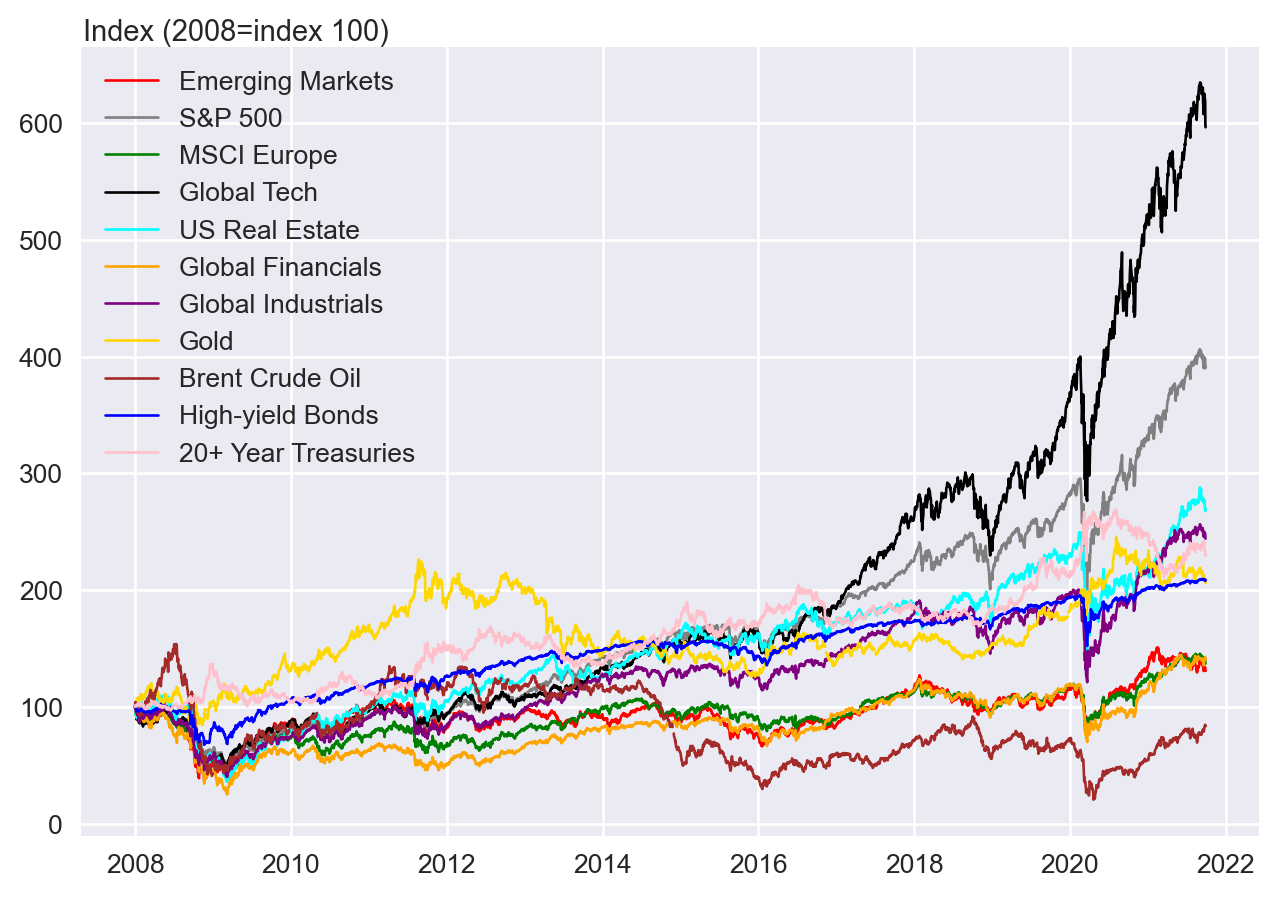

In [44]:
fig, ax = plt.subplots(1, 1, dpi=190)
ax.plot(index["EEM"], label="Emerging Markets", c="red",linewidth=1)
ax.plot(index["IVV"], label="S&P 500", c="grey",linewidth=1)
ax.plot(index["IEV"], label="MSCI Europe", c="green",linewidth=1)
ax.plot(index["IXN"], label="Global Tech", c="black",linewidth=1)
ax.plot(index["IYR"], label="US Real Estate", c="aqua",linewidth=1)
ax.plot(index["IXG"], label="Global Financials", c="orange",linewidth=1)
ax.plot(index["EXI"], label="Global Industrials", c="purple",linewidth=1)
ax.plot(index["GC=F"], label="Gold", c="Gold",linewidth=1)
ax.plot(index["BZ=F"], label="Brent Crude Oil", c="brown",linewidth=1)
ax.plot(index["HYG"], label="High-yield Bonds", c="blue",linewidth=1)
ax.plot(index["TLT"], label="20+ Year Treasuries", c="pink",linewidth=1)
ax.set_ylabel('Index (2008=index 100)',loc='top', rotation = 0, labelpad = -140) 
ax.legend()
fig.savefig("Stocks_index_plot.png", bbox_inches = 'tight', pad_inches = 0.1)

**Fitter fordelinger og laver PDF'er for udvalgte tickers, samt plotter PDF med real world data**

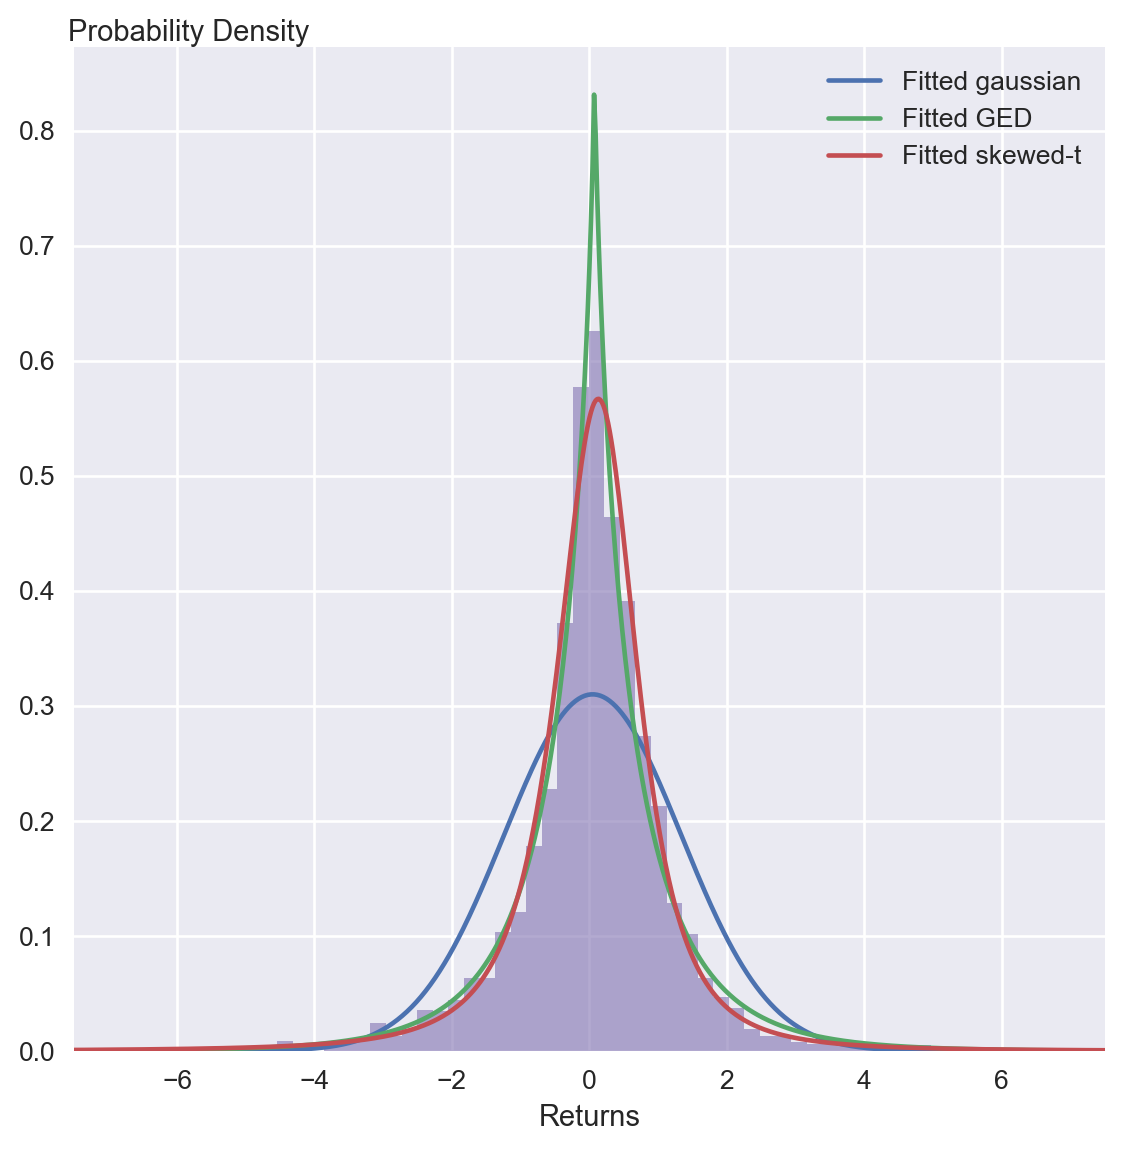

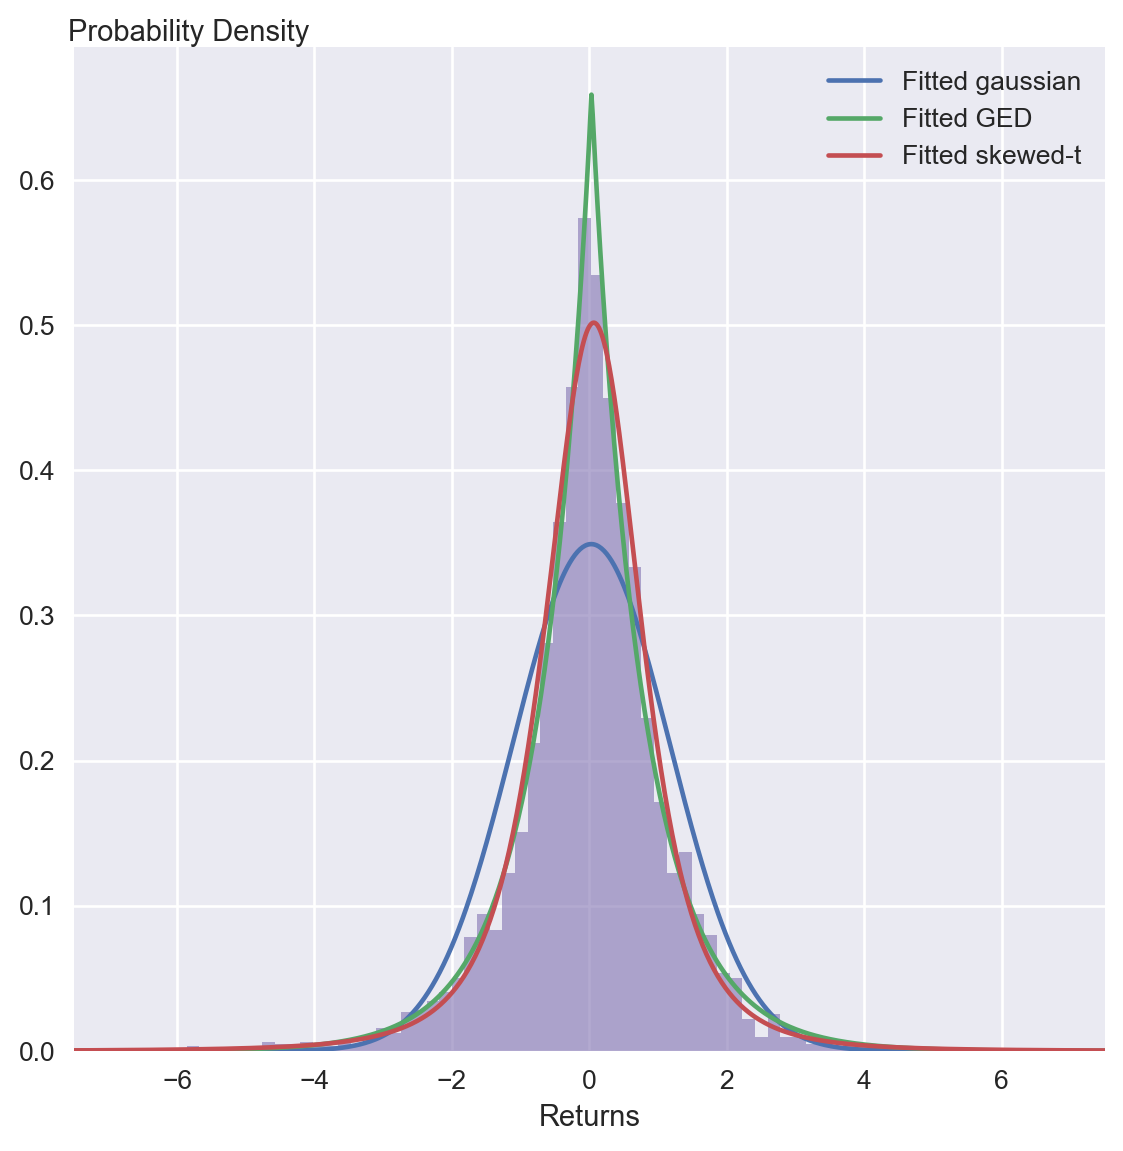

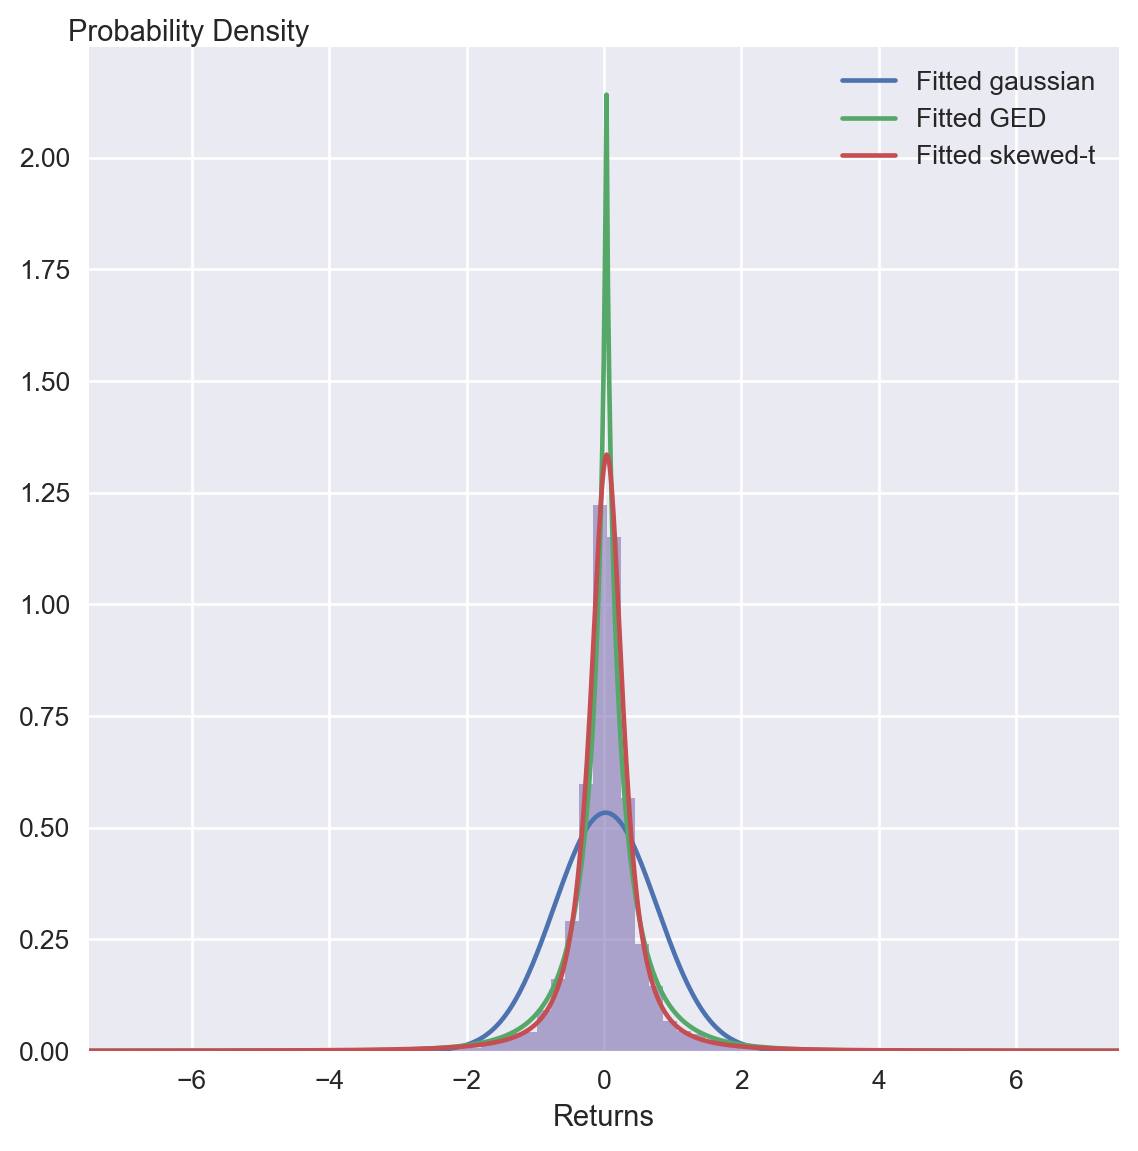

In [47]:
ticker_list=["IVV","GC=F","HYG"]

for ticker in ticker_list:
    mu, std = scipy.norm.fit(returns[ticker]) #normal distribution fi#t
    beta, loc_ged, scale_ged = scipy.gennorm.fit(returns[ticker]) #GED f#it
    df, nc_t, loc_t, scale_t = scipy.nct.fit(returns[ticker]) #skewed student's t distrubiton fit

    #draw data
    xmin = returns[ticker].min()
    xmax = returns[ticker].max()
    x = np.linspace(xmin, xmax, 1000)

    normal_data=scipy.norm.pdf(x, mu, std)
    GED_data=scipy.gennorm.pdf(x, beta,loc_ged,scale_ged)
    t_data=scipy.nct.pdf(x, df,nc_t,loc_t,scale_t)
    
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=190)
    ax.plot(x, normal_data, label="Fitted gaussian")#, c="blue")
    ax.plot(x, GED_data, label="Fitted GED")#, c = "black")
    ax.plot(x, t_data, label ="Fitted skewed-t")#, c="red")
    ax.hist(returns[ticker], bins=100, alpha=0.6, density = True)
    ax.set_xlim(-7.5, 7.5)
    ax.legend()
    ax.set_xlabel('Returns') 
    ax.set_ylabel('Probability Density',loc='top', rotation = 0, labelpad = -110) 
    fig.savefig(f"Density_{ticker}.png", bbox_inches = 'tight', pad_inches = 0.1)

Fitter GARCH model og plotter data

In [ ]:
#indsæt GARCH del

In [ ]:
f, ax1 = plt.subplots(1, 1, figsize=(15,12))
ax1.plot(returns[ticker], alpha=.8)
ax1.set_ylabel('Yearly Returns',loc='top', rotation = 0, labelpad = -100)
ax1.set_ylim((-0.35,0.35))
#plt.savefig("Empirical timeseries.png", bbox_inches = 'tight', pad_inches = 0.1)

f, ax2 = plt.subplots(1, 1, figsize=(15,12))
ax2.plot(normal_data, alpha=.8)
ax2.set_ylabel('Yearly Returns',loc='top', rotation = 0, labelpad = -100)
ax2.set_ylim((-0.35,0.35))
#plt.savefig("Gaussian timeseries.png", bbox_inches = 'tight', pad_inches = 0.1)

f, ax3 = plt.subplots(1, 1, figsize=(15,12))
ax3.plot(GED_data, alpha=.8)
ax3.set_ylabel('Yearly Returns',loc='top', rotation = 0, labelpad = -100)
ax3.set_ylim((-0.35,0.35))
#plt.savefig("GED timeseries.png", bbox_inches = 'tight', pad_inches = 0.1)

f, ax4 = plt.subplots(1, 1, figsize=(15,12))
ax4.plot(t_data, alpha=.8)
ax4.set_ylabel('Yearly Returns',loc='top', rotation = 0, labelpad = -100)
ax4.set_ylim((-0.35,0.35))
#plt.savefig("Skewed Student's t timeseries.png", bbox_inches = 'tight', pad_inches = 0.1)

**Laver Jarque bera normalitets test**

In [48]:
mean = returns.mean()
std = returns.std()
#normality test
jarque = returns.apply(scipy.jarque_bera, axis=0)
p_values = jarque.iloc[1]
#skewed students t parameters
t_dist= returns.apply(scipy.nct.fit, axis=0) 
df_t=t_dist.iloc[0]
nc_t=t_dist.iloc[1]
loc_t=t_dist.iloc[2]
scale_t=t_dist.iloc[3]

row_names = pd.Index(['Mean', 'Std', 'P_value Jarque', 'Degrees of freedom','Non central','Location','Scale'])
pd.DataFrame([mean, std, p_values, df_t, nc_t, loc_t, scale_t], columns = tickers, index = row_names)

,EEM,IVV,IEV,IXN,IYR,IXG,EXI,GC=F,BZ=F,HYG,TLT
Mean,0.025575,0.047686,0.021334,0.062045,0.048386,0.026638,0.035988,0.027484,0.024074,0.023993,0.028559
Std,1.892213,1.287214,1.559061,1.443595,1.980029,1.829331,1.426105,1.142898,2.417819,0.748005,0.949779
P_value Jarque,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Degrees of freedom,2.793063,2.153939,2.472871,2.612289,1.814981,2.105348,2.497774,3.066842,2.482869,1.732388,5.705112
Non central,-0.198654,-0.156162,-0.187792,-0.194975,-0.126854,-0.164831,-0.178021,-0.091497,-0.081249,-0.064358,-0.145674
Location,0.299283,0.204796,0.253989,0.292532,0.197760,0.243126,0.240932,0.119034,0.168285,0.053952,0.153021
Scale,1.050915,0.627747,0.840901,0.828917,0.775252,0.868734,0.786651,0.733595,1.326020,0.260125,0.758079
